# An Ametrano-Bianchetti companion

In this notebook, I'll reproduce the results of the paper by F. M. Ametrano and M. Bianchetti, _Everything You Always Wanted to Know About Multiple Interest Rate Curve Bootstrapping but Were Afraid to Ask_ (April 2, 2013). The paper is available at SSRN: http://ssrn.com/abstract=2219548.

I won't follow strictly the structure of the paper which, as usual for this kind of work, starts by laying down a theoretical framework.  This notebook is meant to be read side to side with it, so there's no reason for to repeat that part.  Instead, I'll jump ahead to the bootstrapping example in section 5 of the paper; and, as we proceed and add features in the code, I'll refer to the corresponding earlier sections and subsections.

Without further ado, let's import a few modules we'll need (including, of course, QuantLib) and set the global evaluation date to the reference date used in the paper.

In [1]:
import QuantLib as ql

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import date

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

## Market data

The authors provided the full set of market data they used for their calculations; they're in figure 4, 6, 7, 9, 10, 11, 13 and 15 of the paper.  If you're reading this from a live Jupyter server—as you should—you can find them in the csv files listed in the file browser on the left of this notebook (you can click on the folder icon to expand it, if it isn't already open); double-clicking the files will open them in a viewer and allow you to examine them.  The following few cells load them in memory and make them ready to use.  For brevity, only the mid quotes have been included; for similarity with other instruments, the IRS data in figures 9, 10 and 11 have been included in a single data file.

In [4]:
all_deposit_data = pd.read_csv(
    "eur-deposits.csv",
    parse_dates=["Start date", "Maturity date"],
)

In [5]:
all_fra_data = pd.read_csv(
    "eur-fra.csv",
    parse_dates=["Start date", "Maturity date"],
)

In [6]:
all_futures_data = pd.read_csv(
    "eur-futures.csv",
    parse_dates=["Underlying start date", "Underlying end date"],
)

In [7]:
all_irs_data = pd.read_csv(
    "eur-irs.csv",
    parse_dates=["Start date", "Maturity"],
)

In [8]:
all_ois_data = pd.read_csv(
    "eur-ois.csv",
    parse_dates=["Start date", "Maturity"],
)

In [9]:
all_irbs_data = pd.read_csv(
    "eur-irbs.csv",
    parse_dates=["Start date", "Maturity date"],
)

## Eonia yield curve

Following the sequence of section 5, we start by bootstrapping the Eonia curve.  There's a reason for that; this curve is going to be used as a discount curve in the bootstrap of all the other forecast curves.  Our aim is to reproduce the two plots in figure 26.

We start by instantiating helpers for all the rates used in the bootstrapping process, as listed in figure 25 of the paper.

The first three instruments are three 1-day deposit that give us discounting between today and the day after spot. They are modeled by three instances of the `DepositRateHelper` class, with a tenor of 1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit starting on the spot date).

Note that these helpers, and the library in general, requires rates to be in decimal format; that is, a 1% rate must be entered as 0.01.  Therefore, we need to divide the quotes by 100.

In [10]:
depo_data = all_deposit_data[all_deposit_data["Underlying"] == "Euribor1D"]
depo_data

,Instrument,Quote,Underlying,Start date,Maturity date,Settlement days,Convention,End of month
0,Depo ON,0.04,Euribor1D,2012-12-11,2012-12-12,0,Following,False
1,Depo TN,0.04,Euribor1D,2012-12-12,2012-12-13,1,Following,False
2,Depo SN,0.04,Euribor1D,2012-12-13,2012-12-14,2,Following,False


In [11]:
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period("1D"),
        row["Settlement days"],
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for _, row in depo_data.iterrows()
]

Then, we have a series of OIS quotes for the first month. They are modeled by instances of the `OISRateHelper` class with varying tenors. They also require an instance of the `Eonia` class (the paper is from 2013, before the introduction of ESTR), which doesn't need a forecast curve and can be shared between the helpers.

Another note: there are examples floating around the web (and, a while back, in our own examples) in which the index passed to the helpers is instantiated by passing it a `RelinkableYieldTermStructureHandle`, and the handle is later linked to the curve we're bootstrapping.  Don't do that.  It will create a cycle between objects and result in a memory leak.  When we have the curve, we'll use it to create another instance of the index.

In [12]:
eonia = ql.Eonia()

In [13]:
ois_data = all_ois_data[:4]
ois_data

,Instrument,Quote,Underlying,Start date,Maturity
0,EON1W,0.070,Eonia,2012-12-13,2012-12-20
1,EON2W,0.069,Eonia,2012-12-13,2012-12-27
2,EON3W,0.078,Eonia,2012-12-13,2013-01-03
3,EON1M,0.074,Eonia,2012-12-13,2013-01-14


In [14]:
def tenor(code):
    # starts with EON, then comes the period
    return code[3:]


helpers += [
    ql.OISRateHelper(
        2,  # Settlement days
        ql.Period(tenor(row["Instrument"])),
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        eonia,
    )
    for _, row in ois_data.iterrows()
]

Next, five OIS forwards on ECB dates. For these, we need to instantiate the `DatedOISRateHelper` class and specify start and end dates explicitly.

In [15]:
ois_fwd = all_ois_data[33:38]
ois_fwd

,Instrument,Quote,Underlying,Start date,Maturity
33,EONECBFEB13,0.046,Eonia,2013-01-16,2013-02-13
34,EONECBMAR13,0.016,Eonia,2013-02-13,2013-03-13
35,EONECBAPR13,-0.007,Eonia,2013-03-13,2013-04-10
36,EONECBMAY13,-0.013,Eonia,2013-04-10,2013-05-08
37,EONECBJUN13,-0.014,Eonia,2013-05-08,2013-06-12


In [16]:
helpers += [
    ql.DatedOISRateHelper(
        ql.Date.from_date(row["Start date"]),
        ql.Date.from_date(row["Maturity"]),
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        eonia,
    )
    for _, row in ois_fwd.iterrows()
]

Finally, we add OIS quotes up to 30 years.  These have a rolling maturity, so we go back to the `OisRateHelper` class.

In [17]:
ois_data = all_ois_data[15:33]
ois_data

,Instrument,Quote,Underlying,Start date,Maturity
15,EON15M,0.002,Eonia,2012-12-13,2014-03-13
16,EON18M,0.008,Eonia,2012-12-13,2014-06-13
17,EON21M,0.021,Eonia,2012-12-13,2014-09-15
18,EON2Y,0.036,Eonia,2012-12-13,2014-12-15
19,EON3Y,0.127,Eonia,2012-12-13,2015-12-14
20,EON4Y,0.274,Eonia,2012-12-13,2016-12-13
21,EON5Y,0.456,Eonia,2012-12-13,2017-12-13
22,EON6Y,0.647,Eonia,2012-12-13,2018-12-13
23,EON7Y,0.827,Eonia,2012-12-13,2019-12-13
24,EON8Y,0.996,Eonia,2012-12-13,2020-12-14


In [18]:
helpers += [
    ql.OISRateHelper(
        2,
        ql.Period(tenor(row["Instrument"])),
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        eonia,
    )
    for _, row in ois_data.iterrows()
]

The curve is an instance of `PiecewiseLogCubicDiscount` (corresponding to the `PiecewiseYieldCurve<Discount,LogCubic>` class in C++); the argument for this choice is made in section 4.5 of the paper.  We let the reference date of the curve move with the global evaluation date, by specifying it as 0 days after the latter on the TARGET calendar.

The day counter chosen is not of much consequence, as it is only used internally to convert dates into times.  As mentioned in section 4.2, a additive day-count convention is to be preferred; that is, one for which, given three dates $d_1$, $d_2$ and $d_3$,

$$ \tau(d_1, d_3) = \tau(d_1, d_2) + \tau(d_2, d_3) $$

In practice, this usually means the Act/360 or Act/365 conventions.

Also, we enable extrapolation beyond the maturity of the last helper; that is mostly for convenience as we retrieve rates to plot the curve near its far end.

In [19]:
eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual365Fixed())
eonia_curve_c.enableExtrapolation()

To compare the curve with the one shown in figure 26 of the paper, we can retrieve daily overnight rates over its first two years and plot them:

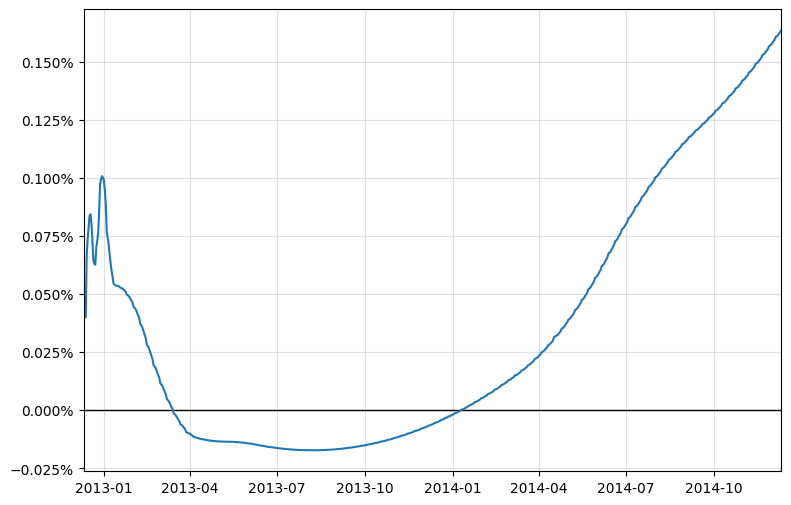

In [20]:
today = eonia_curve_c.referenceDate()
end = today + ql.Period(2, ql.Years)
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber() + 1)]
rates_c = [
    eonia_curve_c.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates_c, "-")
ax.grid(alpha=0.4);

However, we still have work to do. Out plot above shows a rather large bump at the end of 2012 which is not present in the paper. To remove it, we need to model properly the turn-of-year effect.

### Turn-of-year jumps

As explained in section 4.8 of the paper, the turn-of-year effect is a jump in interest rates due to an increased demand for liquidity at the end of the year.  The jump is embedded in any quoted rates that straddle the end of the year, and must be treated separately; the `YieldTermStructure` class allows this by taking any number of jumps, modeled as additional discount factors, and applying them at the specified dates.

Our current problem, however, is to estimate the size of the jump. To simplify analysis, we turn to flat forward rates instead of log-cubic discounts; thus, we instantiate a `PiecewiseFlatForward` curve (corresponding to `PiecewiseYieldCurve<ForwardRate,BackwardFlat>` in C++).

In [21]:
eonia_curve_ff = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

To show the jump more clearly, I'll restrict the plot to the first 6 months:

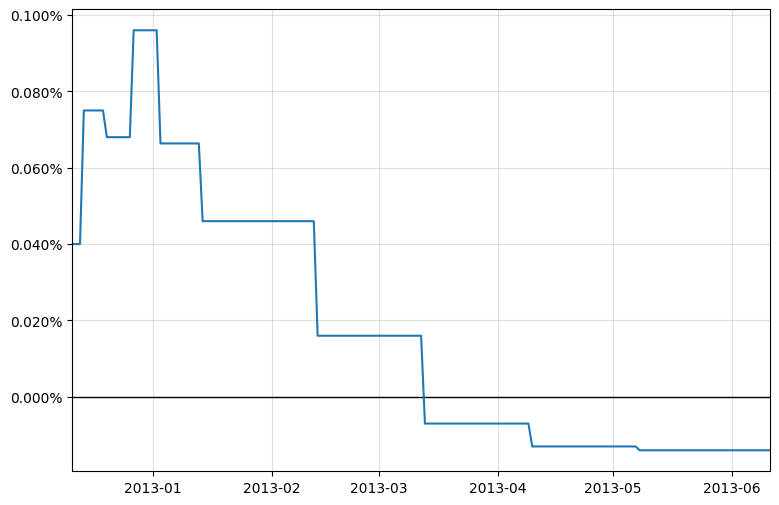

In [22]:
end = today + ql.Period(6, ql.Months)
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber() + 1)]
rates_ff = [
    eonia_curve_ff.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates_ff, "-")
ax.grid(alpha=0.4);

As we see, the forward ending at the beginning of January 2013 is out of line. In order to estimate the jump, we need to estimate a "clean" forward that doesn't include it.

A possible estimate (although not the only one) can be obtained by interpolating the forwards around the one we want to replace. To do so, we extract the values of the forwards rates and their corresponding dates.

In [23]:
nodes = list(eonia_curve_ff.nodes())

If we look at the first few nodes, we can clearly see that the seventh (the one for January 2013) is out of line.

In [24]:
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.00046638054590758754)]

To create a curve that doesn't include the jump, we replace the relevant forward rate with a simple average of the ones that precede and follow...

In [25]:
nodes[6] = (nodes[6][0], (nodes[5][1] + nodes[7][1]) / 2.0)
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.000681123301587661),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.00046638054590758754)]

...and instantiate a `ForwardCurve` with the modified nodes.

In [26]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ql.ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())

For illustration, we can extract daily overnight nodes from the doctored curve and plot them alongside the old ones:

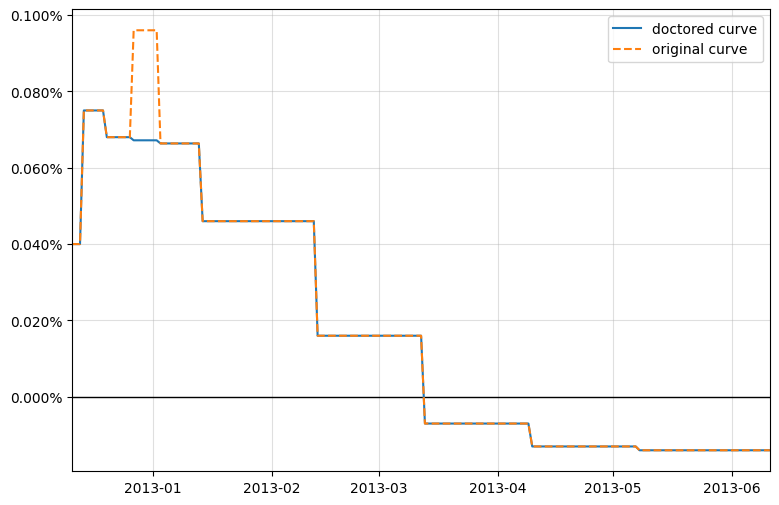

In [27]:
temp_rates = [
    temp_curve.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], temp_rates, "-", label="doctored curve")
ax.plot([d.to_date() for d in dates], rates_ff, "--", label="original curve")
ax.grid(alpha=0.4)
ax.legend();

Now we can estimate the size of the jump. As the paper hints, it's more an art than a science. I've been able to reproduce fairly closely the results of the paper by extracting from both curves the forward rate over the two weeks around the end of the year:

In [28]:
d1 = ql.Date(31, ql.December, 2012) - ql.Period(1, ql.Weeks)
d2 = ql.Date(31, ql.December, 2012) + ql.Period(1, ql.Weeks)

In [29]:
F = eonia_curve_ff.forwardRate(d1, d2, ql.Actual360(), ql.Simple)
F_1 = temp_curve.forwardRate(d1, d2, ql.Actual360(), ql.Simple)
print(F)
print(F_1)

0.081531 % Actual/360 simple compounding
0.067122 % Actual/360 simple compounding


We want to attribute the whole jump to the last day of the year, so we rescale it according to

$$
(F-F_1) \cdot t_{12} = J \cdot t_J
$$

where $t_{12}$ is the time between the two dates and $t_J$ is the time between the start and end date of the end-of-year overnight deposit. This gives us a jump close to the value of 10.2 basis points reported in the paper.

In [30]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1, d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(
    ql.Date(31, ql.December, 2012), ql.Date(2, ql.January, 2013)
)
J = (F.rate() - F_1.rate()) * t12 / t_j
print(f"{J:.4%}")

0.1009%


As I mentioned previously, the jump can be added to the curve as a corresponding discount factor $1/(1+J \cdot t_J)$ on the last day of the year.  The information can be passed to the curve constructor, giving us a new instance:

In [31]:
B = 1.0 / (1.0 + J * t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31, ql.December, 2012)]
eonia_curve_j = ql.PiecewiseFlatForward(
    0, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates
)

Retrieving daily overnight rates from the new curve and plotting them, we can see the jump quite clearly:

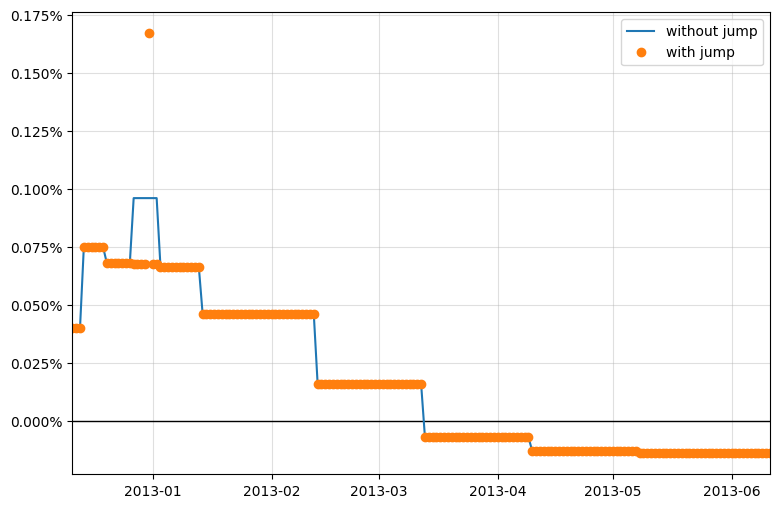

In [32]:
rates_j = [
    eonia_curve_j.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates_ff, "-", label="without jump")
ax.plot([d.to_date() for d in dates], rates_j, "o", label="with jump")
ax.grid(alpha=0.4)
ax.legend();

We can now go back to log-cubic discounts and add the jump.

In [33]:
eonia_curve = ql.PiecewiseLogCubicDiscount(
    0, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates
)
eonia_curve.enableExtrapolation()

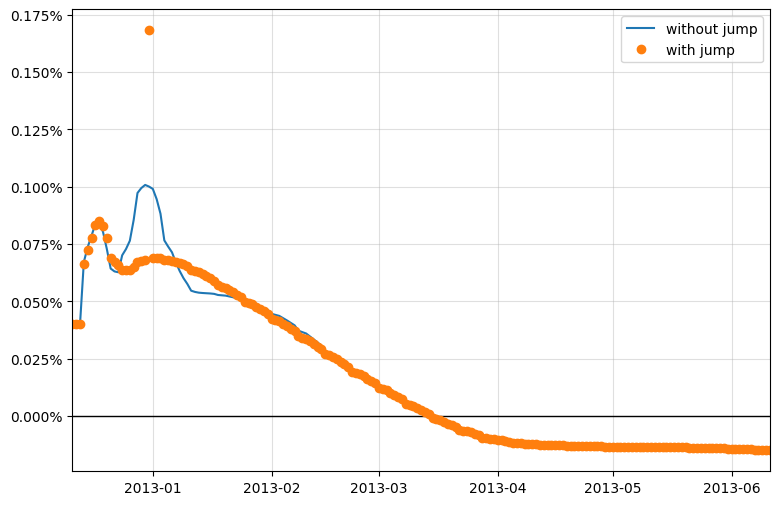

In [34]:
rates_c = [
    eonia_curve_c.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates = [
    eonia_curve.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates_c, "-", label="without jump")
ax.plot([d.to_date() for d in dates], rates, "o", label="with jump")
ax.grid(alpha=0.4)
ax.legend();

As you can see, the large bump is gone now.  The two plots in figure 26 can be reproduced as follows (omitting the jump at the end of 2013 for brevity, and the flat forwards for clarity):

In [35]:
eonia_curve_2 = ql.PiecewiseLogLinearDiscount(
    0, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates
)
eonia_curve_2.enableExtrapolation()

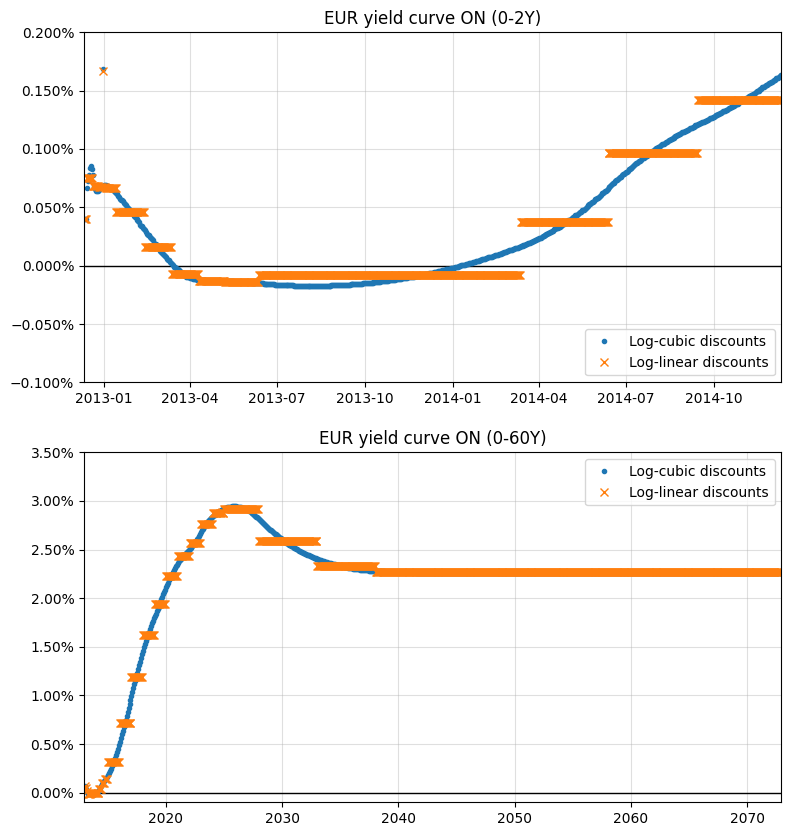

In [36]:
fig = plt.figure(figsize=(9, 10))

dates = [today + ql.Period(i, ql.Days) for i in range(0, 365 * 2 + 1)]
rates = [
    eonia_curve.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates_2 = [
    eonia_curve_2.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("EUR yield curve ON (0-2Y)")
ax1.axhline(0.0, linewidth=1, color="black")
ax1.set_xlim(min(dates).to_date(), max(dates).to_date())
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_ylim(-0.001, 0.002)
ax1.plot([d.to_date() for d in dates], rates, ".", label="Log-cubic discounts")
ax1.plot(
    [d.to_date() for d in dates],
    rates_2,
    "x",
    label="Log-linear discounts",
)
ax1.grid(alpha=0.4)
ax1.legend(loc="lower right")

dates = [today + ql.Period(i, ql.Months) for i in range(0, 12 * 60 + 1)]
rates = [
    eonia_curve.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates_2 = [
    eonia_curve_2.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("EUR yield curve ON (0-60Y)")
ax2.axhline(0.0, linewidth=1, color="black")
ax2.set_xlim(min(dates).to_date(), max(dates).to_date())
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.set_ylim(-0.001, 0.035)
ax2.plot([d.to_date() for d in dates], rates, ".", label="Log-cubic discounts")
ax2.plot(
    [d.to_date() for d in dates],
    rates_2,
    "x",
    label="Log-linear discounts",
)
ax2.grid(alpha=0.4)
ax2.legend(loc="upper right");

A final word of warning: as you saw, the estimate of the jumps is not an exact science, so it's best to check it manually and not to leave it to an automated procedure.

Moreover, jumps might be present at the end of each month, as reported for instance in [Paolo Mazzocchi's presentation at the QuantLib User Meeting 2014](https://speakerdeck.com/nando1970/eonia-jumps-and-proper-euribor-forwarding). This, too, suggests particular care in building the Eonia curve.

## 6-months Euribor curve

As we'll see, most of the Euribor curves for different tenors have their own quirks.

I'll start from the 6-months Euribor curve, which is somewhat simpler due to having a number of quoted rates directly available for bootstrapping. The figure we want to reproduce is figure 32; the instruments are listed in figure 31.

The first instrument used in the paper if the TOM 6-months FRA, which can be instantiated as a 6-months deposit with 3 fixing days.

In [37]:
depo_data = all_fra_data[9:10]
depo_data

,Instrument,Quote,Underlying,Start date,Maturity date
9,FRA Tom6M,0.312,Euribor6M,2012-12-14,2013-06-14


In [38]:
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period(6, ql.Months),
        3,
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for _, row in depo_data.iterrows()
]

Then comes a strip of 6-months FRA up to 2 years maturity.  The `FraRateHelper` class needs an instance of the corresponding index that, again, we instantiate without passing it a handle.

In [39]:
fra_data = all_fra_data[10:28]
fra_data

,Instrument,Quote,Underlying,Start date,Maturity date
10,FRA 1x7,0.293,Euribor6M,2013-01-14,2013-07-15
11,FRA 2x8,0.272,Euribor6M,2013-02-13,2013-08-13
12,FRA 3x9,0.260,Euribor6M,2013-03-13,2013-09-13
13,FRA 4x10,0.256,Euribor6M,2013-04-15,2013-10-15
14,FRA 5x11,0.252,Euribor6M,2013-05-13,2013-11-13
15,FRA 6x12,0.248,Euribor6M,2013-06-13,2013-12-13
16,FRA 7x13,0.254,Euribor6M,2013-07-15,2014-01-15
17,FRA 8x14,0.261,Euribor6M,2013-08-13,2014-02-13
18,FRA 9x15,0.267,Euribor6M,2013-09-13,2014-03-13
19,FRA 10x16,0.279,Euribor6M,2013-10-14,2014-04-14


In [40]:
euribor6m = ql.Euribor6M()

In [41]:
def start_months(code):
    # we want to extract e.g. the 12 from "FRA 12x18"
    _, tenor = code.split(" ")
    start, end = tenor.split("x")
    return int(start)


helpers += [
    ql.FraRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        start_months(row["Instrument"]),
        euribor6m,
    )
    for _, row in fra_data.iterrows()
]

Finally, we have a selection of swap rates with maturities from 3 to 60 years.  As the paper explains (see section 4.7), the curve being bootstrapped will be used only for forecasting the 6-months Euribor fixings paid by the floating leg; all the payments will be discounted by means of the OIS curve.  In the implementation, this is done by wrapping the Eonia curve in a `Handle` and passing it as an extra argument to the `SwapRateHelper` constructor.

In [42]:
irs_data = all_irs_data.loc[[5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 22, 27, 32, 33, 34, 35, 36]]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
5,AB6E3Y,0.424,Euribor6M,2012-12-13,2015-12-14
6,AB6E4Y,0.576,Euribor6M,2012-12-13,2016-12-13
7,AB6E5Y,0.762,Euribor6M,2012-12-13,2017-12-13
8,AB6E6Y,0.954,Euribor6M,2012-12-13,2018-12-13
9,AB6E7Y,1.135,Euribor6M,2012-12-13,2019-12-13
10,AB6E8Y,1.303,Euribor6M,2012-12-13,2020-12-14
11,AB6E9Y,1.452,Euribor6M,2012-12-13,2021-12-13
12,AB6E10Y,1.584,Euribor6M,2012-12-13,2022-12-13
14,AB6E12Y,1.809,Euribor6M,2012-12-13,2024-12-13
17,AB6E15Y,2.037,Euribor6M,2012-12-13,2027-12-13


In [43]:
discount_curve = ql.YieldTermStructureHandle(eonia_curve)

In [44]:
def tenor(code):
    # starts with AB6E, then comes the tenor
    return code[4:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period(tenor(row["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor6m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for _, row in irs_data.iterrows()
]

This will give us a decent Euribor curve, that we can display by sampling 6-months forward rates at a number of dates.

In [45]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

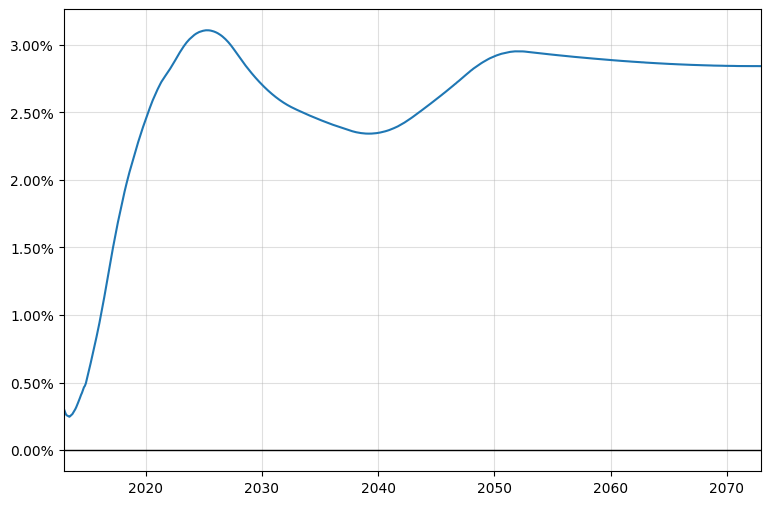

In [46]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates, "-")
ax.grid(alpha=0.4);

At the scale of the plot, this seems to work and to match figure 32 in the paper; but looking closely at the first part of the curve, you can see a glitch (some kind of dip) in the last part of 2014, when the FRA strip ends.

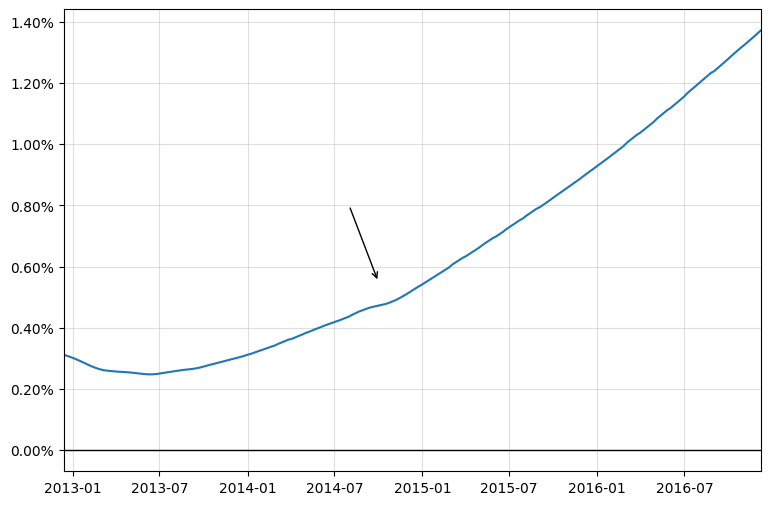

In [47]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot([d.to_date() for d in dates], rates, "-")
ax.grid(alpha=0.4)
ax.annotate(
    "",
    xy=(date(2014, 10, 1), 0.0055),
    xytext=(date(2014, 8, 1), 0.008),
    arrowprops=dict(arrowstyle="->"),
);

### Synthetic deposits

In short, the reason is that the short end of the curve (which is required for pricing FRAs; for instance, the 1x7 FRA required the discount factor at 1 month from now) is extrapolated backwards from the first quoted pillar at 6 months and is not quite correct. This leads to oscillations as soon as the curve is out of the tight strip of FRA quotes.

One way to correct this is to add synthetic deposits with short tenors, as explained in section 4.4.2 of the paper. To begin with, let's save the original curve to another variable for later comparison.

In [48]:
euribor6m_curve_0 = euribor6m_curve

As detailed in the paper, one can model the basis between the Euribor market quotes and the corresponding OIS-based rates as a polynomial; that is, following equation 88,

$$
R_{x}(T_1,T_2) \tau(T_1,T_2) = R_{on}(T_1,T_2) \tau(T_1,T_2) + \Delta(T_1,T_2)
$$

In the paper, the expression for $\Delta(T_1,T_2)$ is given by equation 90, that is,

$$
\Delta(T_1, T_2) = \alpha \cdot (T_2-T_1) + \frac{1}{2} \beta \cdot (T_2-T_1)^2
                 + \frac{1}{3} \gamma \cdot (T_2-T_1)^3 + \ldots
$$

However, the above leads to problems when trying to solve for more than one coefficient.  Following [a later formulation](https://speakerdeck.com/nando1970/eonia-jumps-and-proper-euribor-forwarding), I'll express the instantaneous basis instead as 

$$
\delta(t) = \alpha + \beta \cdot t + \gamma \cdot t^2 + \ldots
$$

which leads to

$$
\Delta(T_1, T_2) = \int_{T_1}^{T_2} \delta(t)
                 = \alpha \cdot (T_2-T_1) + \frac{1}{2} \beta \cdot (T_2^2-T_1^2)
                 + \frac{1}{3} \gamma \cdot (T_2^3-T_1^3) + \ldots
$$

Once the basis is known, we can calculate synthetic deposit rates $R(0,T)$ for any maturity $T$.

Depending on how many polynomial coefficients we want to determine, we'll need a corresponding number of market quotes; by replacing their values and those of the OIS rates in equation 88 we can solve for $\alpha$, $\beta$ and any other coefficient.

For a constant polynomial, we'll need one quote to determine $\alpha$; we can use the TOM 6-months deposit that the Euribor curve reprices exactly.

In [49]:
d = ql.TARGET().advance(spot, 1, ql.Days)
F_x = euribor6m_curve_0.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple
).rate()
F_on = eonia_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple
).rate()
day_counter = euribor6m.dayCounter()
T_x = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))
alpha = F_x - F_on
print(alpha)

0.0029492968598198548


From the basis, we can instantiate synthetic deposits for a number of maturities below 6 months.

In [50]:
synth_helpers = []
for tenor in ["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M"]:
    tenor = ql.Period(tenor)
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, tenor))
    F_on = eonia_curve.forwardRate(
        spot,
        ql.TARGET().advance(spot, tenor),
        ql.Actual360(),
        ql.Simple,
    ).rate()
    F = F_on + alpha
    print(f"{tenor}: {F * 100:.4} %")
    synth_helpers.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(F)),
            tenor,
            2,
            ql.TARGET(),
            ql.Following,
            False,
            ql.Actual360(),
        )
    )

1D: 0.3349 %
1W: 0.3649 %
2W: 0.3639 %
3W: 0.3729 %
1M: 0.3689 %
2M: 0.3559 %
3M: 0.3419 %
4M: 0.3272 %
5M: 0.3188 %


...after which we can create a new curve, which seems to have a smaller dip:

In [51]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), helpers + synth_helpers, ql.Actual365Fixed()
)
euribor6m_curve.enableExtrapolation()

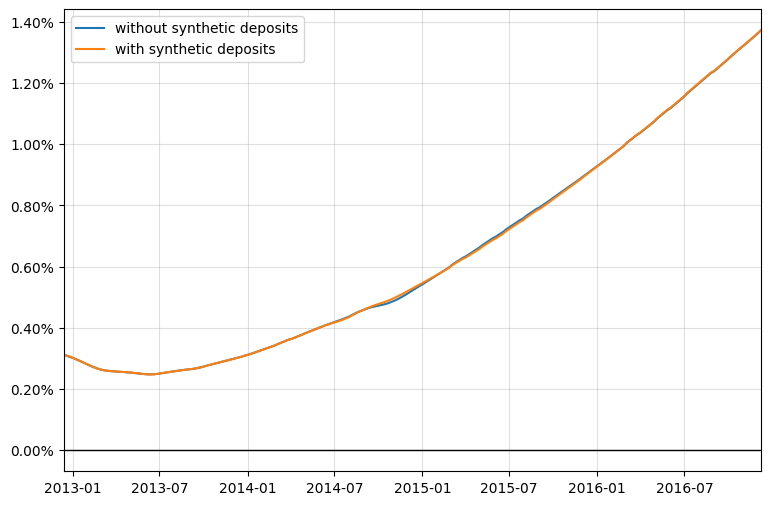

In [52]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates_0 = [
    euribor6m_curve_0.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot(
    [d.to_date() for d in dates],
    rates_0,
    "-",
    label="without synthetic deposits",
)
ax.plot(
    [d.to_date() for d in dates],
    rates,
    "-",
    label="with synthetic deposits",
)
ax.grid(alpha=0.4)
ax.legend();

By choosing to sample at different dates, we can zoom into the affected area. The original curve is the dotted line; the new curve is the solid one.

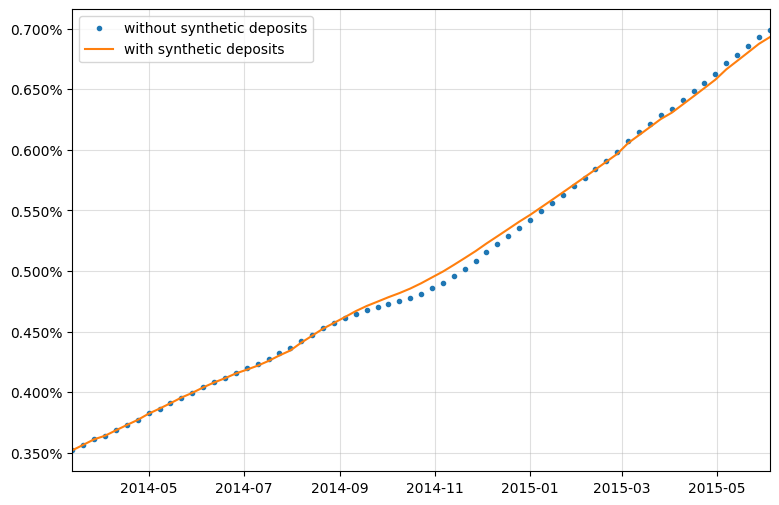

In [53]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(65, 130)]
rates_0 = [
    euribor6m_curve_0.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot(
    [d.to_date() for d in dates],
    rates_0,
    ".",
    label="without synthetic deposits",
)
ax.plot(
    [d.to_date() for d in dates],
    rates,
    "-",
    label="with synthetic deposits",
)
ax.grid(alpha=0.4)
ax.legend();

If we wanted to determine more coefficients for the basis, we'd have to select more quotes and solve a linear system. For instance, to determine both $\alpha$ and $\beta$, we can use the TOM 6-months and the 1x7 FRAs.  However, I'll leave this exercise to that mythical creature, the interested reader.

One thing to note: the values I'm getting for the synthetic deposits are not the same as those reported by the paper in figure 17.  I haven't found the reason for the discrepancy.

As for figure 32 in the paper, here's how we can reproduce it:

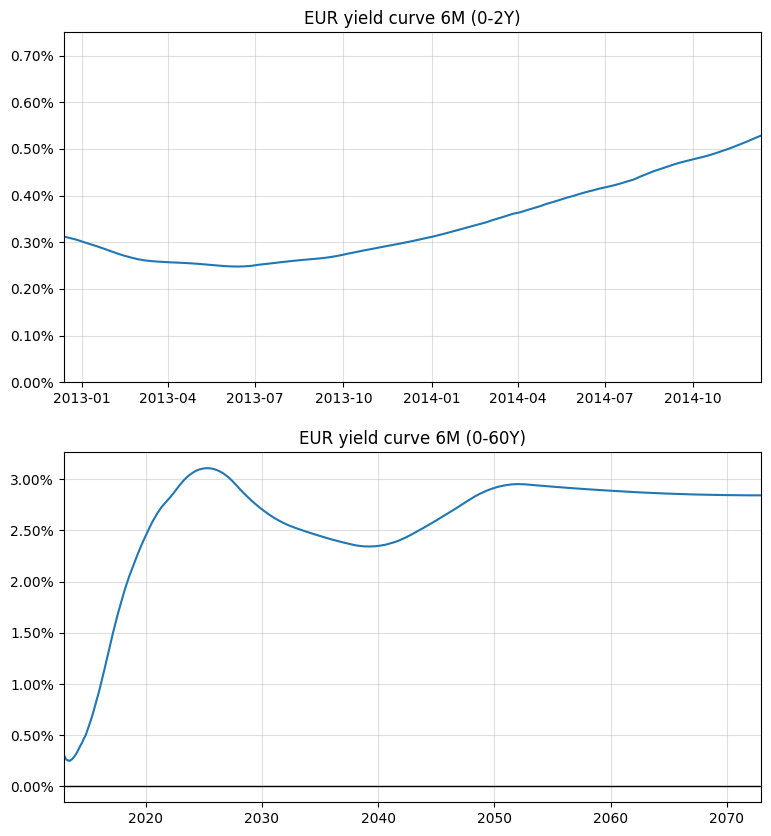

In [54]:
fig = plt.figure(figsize=(9, 10))

spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("EUR yield curve 6M (0-2Y)")
ax1.set_xlim(min(dates).to_date(), max(dates).to_date())
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_ylim(0.0, 0.0075)
ax1.plot([d.to_date() for d in dates], rates, "-")
ax1.grid(alpha=0.4)

spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [
    euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("EUR yield curve 6M (0-60Y)")
ax2.axhline(0.0, linewidth=1, color="black")
ax2.set_xlim(min(dates).to_date(), max(dates).to_date())
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.plot([d.to_date() for d in dates], rates, "-")
ax2.grid(alpha=0.4);

## 12-months Euribor curve

For the 12-months curve, we'll use the instruments listed in figure 33 and reproduce figure 34.

We'll start with the quoted 12-months deposit and 12x24 FRA.

In [55]:
depo_data = all_deposit_data[all_deposit_data["Underlying"] == "Euribor12M"]
depo_data

,Instrument,Quote,Underlying,Start date,Maturity date,Settlement days,Convention,End of month
17,Depo 12M,0.54,Euribor12M,2012-12-13,2013-12-13,2,Mod.Following,True


In [56]:
fra_data = all_fra_data[all_fra_data["Underlying"] == "Euribor12M"]
fra_data

,Instrument,Quote,Underlying,Start date,Maturity date
28,FRA 12x24,0.507,Euribor12M,2013-12-13,2014-12-15


In [57]:
euribor12m = ql.Euribor1Y()
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period("12M"),
        row["Settlement days"],
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for _, row in depo_data.iterrows()
]
helpers += [
    ql.FraRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        12,
        euribor12m,
    )
    for _, row in fra_data.iterrows()
]

Unfortunately, there are no quoted swap rates against 12-months Euribor.  However, the market quotes 6- vs 12-months basis swaps; and more importantly, it quotes them as a portfolio of two IRS, payer and receiver, both accruing annual fixed coupons against Euribor 6M and 12M, respectively. The spread between the two fixed legs is quoted so that it sets the NPV of the portfolio at zero.

Given that the market also quotes the fair fixed rate for one of the two swaps, i.e., the one paying a fixed rate against Euribor 6M, it's straightforward to see that the fair fixed rate for the swap against Euribor 12M can be obtained by just adding the 6M rate to the basis spread: that is, if the NPV of a swap $S_1$ paying $K$ against Euribor 6M is 0, and if the NPV of the portfolio of $S_1$ minus another swap $S_2$ paying $K+S$ against Euribor 12M is also 0, then the NPV of $S_2$ must be 0 as well.

This gives us quoted swap rates against Euribor 12M up to 30 years, which is the longest quoted maturity for basis swaps.

Note that we're keeping the original approach of the paper here, but in more recent versions of QuantLib it's no longer necessary to synthesize swap quotes; the library provides an `IborIborBasisSwapRateHelper` class that can use the basis-spread quote directly.

In [58]:
basis_data = pd.concat([all_irbs_data[36:44], all_irbs_data[45:50]])
basis_data

,Instrument,Quote,Underlying 1st leg,Underlying 2nd leg,Start date,Maturity date
36,6E12E3Y,17.9,Euribor6M,Euribor12M,2012-12-13,2015-12-14
37,6E12E4Y,16.4,Euribor6M,Euribor12M,2012-12-13,2016-12-13
38,6E12E5Y,15.1,Euribor6M,Euribor12M,2012-12-13,2017-12-13
39,6E12E6Y,13.9,Euribor6M,Euribor12M,2012-12-13,2018-12-13
40,6E12E7Y,13.0,Euribor6M,Euribor12M,2012-12-13,2019-12-13
41,6E12E8Y,12.3,Euribor6M,Euribor12M,2012-12-13,2020-12-14
42,6E12E9Y,11.8,Euribor6M,Euribor12M,2012-12-13,2021-12-13
43,6E12E10Y,11.3,Euribor6M,Euribor12M,2012-12-13,2022-12-13
45,6E12E12Y,10.6,Euribor6M,Euribor12M,2012-12-13,2024-12-13
46,6E12E15Y,9.3,Euribor6M,Euribor12M,2012-12-13,2027-12-13


In [59]:
irs_data = all_irs_data.loc[[5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 22, 27, 32]]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
5,AB6E3Y,0.424,Euribor6M,2012-12-13,2015-12-14
6,AB6E4Y,0.576,Euribor6M,2012-12-13,2016-12-13
7,AB6E5Y,0.762,Euribor6M,2012-12-13,2017-12-13
8,AB6E6Y,0.954,Euribor6M,2012-12-13,2018-12-13
9,AB6E7Y,1.135,Euribor6M,2012-12-13,2019-12-13
10,AB6E8Y,1.303,Euribor6M,2012-12-13,2020-12-14
11,AB6E9Y,1.452,Euribor6M,2012-12-13,2021-12-13
12,AB6E10Y,1.584,Euribor6M,2012-12-13,2022-12-13
14,AB6E12Y,1.809,Euribor6M,2012-12-13,2024-12-13
17,AB6E15Y,2.037,Euribor6M,2012-12-13,2027-12-13


While instantiating the helpers, we also need to take into account the fact that the IRS are quoted as percentages and the basis as bps.

In [60]:
def tenor(code):
    # starts with 6E12E, then comes the tenor
    return code[5:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(irs["Quote"] / 100 + basis["Quote"] / 10000)),
        ql.Period(tenor(basis["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor12m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,
    )
    for (_, basis), (_, irs) in zip(basis_data.iterrows(), irs_data.iterrows())
]

Again, we'll be using synthetic helpers to improve the shape of the short end of the curve.  The same procedure we used for the Euribor 6M curve lets us create deposits with a number of maturities below 1 year; I'll skip the calculation and just create helpers with the the resulting rates as reported by the paper, namely, figure 33.

In [61]:
depo_data = [
    ("1M", 0.6537),
    ("3M", 0.6187),
    ("6M", 0.5772),
    ("9M", 0.5563),
]

In [62]:
synth_helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(quote / 100)),
        ql.Period(tenor),
        2,  # Settlement days
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for tenor, quote in depo_data
]

It is also possible to build synthetic FRAs: their construction is explained in the paper. I'll leave it, possibly, to a later version of this notebook; for the time being, I'll just add the finished helpers.

In [63]:
fra_data = [
    (3, 0.4974),
    (6, 0.4783),
    (9, 0.4822),
    (15, 0.5481),
    (18, 0.6025),
]

In [64]:
synth_helpers += [
    ql.FraRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(quote / 100)),
        start_months,
        euribor12m,
    )
    for start_months, quote in fra_data
]

Finally, we can extend the long end of the curve by creating synthetic swaps with maturities above 30 years.  To calculate their rates, we add the swap rates against Euribor 6M (quoted up to 60 years) to the last quoted basis spread.

In [65]:
irs_data = all_irs_data[33:37]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
33,AB6E35Y,2.295,Euribor6M,2012-12-13,2047-12-13
34,AB6E40Y,2.348,Euribor6M,2012-12-13,2052-12-13
35,AB6E50Y,2.421,Euribor6M,2012-12-13,2062-12-13
36,AB6E60Y,2.463,Euribor6M,2012-12-13,2072-12-13


In [66]:
def tenor(code):
    # AB6E, then the tenor
    return code[4:]


last_basis = basis_data["Quote"][basis_data.last_valid_index()]
synth_helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100 + last_basis / 10000)),
        ql.Period(tenor(row["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor12m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for _, row in irs_data.iterrows()
]

Bootstrapping over the whole set of real and synthetic quotes gives us our final Euribor 12M curve:

In [67]:
euribor12m_curve = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), helpers + synth_helpers, ql.Actual365Fixed()
)
euribor12m_curve.enableExtrapolation()

For comparison, we can build another one excluding the synthetic helpers.  Note that this second curve won't extend beyond 30 years.

In [68]:
euribor12m_curve_0 = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
euribor12m_curve_0.enableExtrapolation()

The two curves are plotted together in the two following graphs, which also reproduce figure 34 in the paper.  The solid line corresponds to the complete curve, and the dashed line to the curve without the synthetic helpers.  The differences are obvious, both in the short and in the long end.

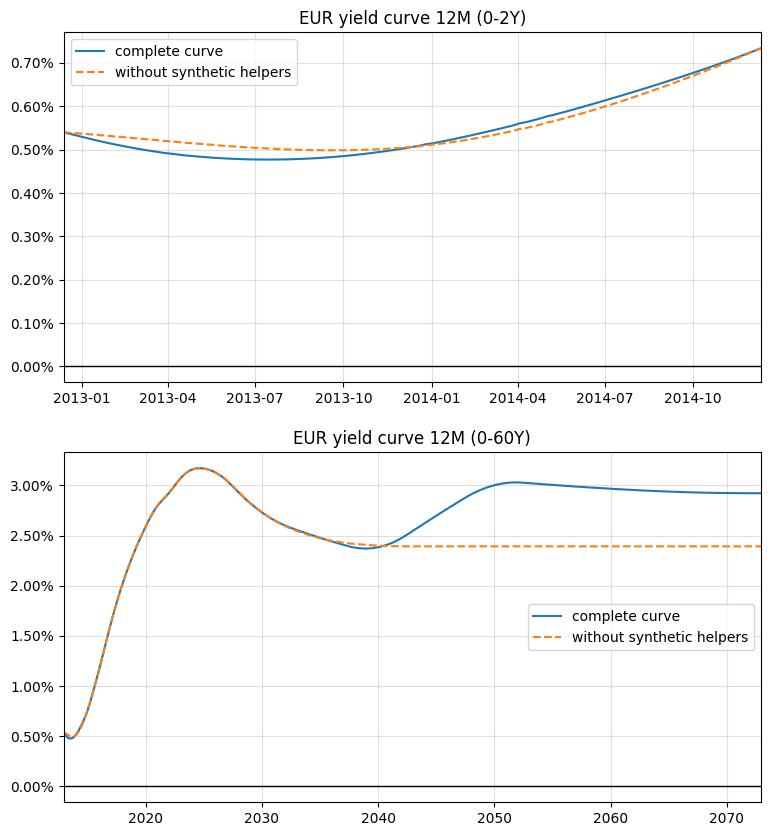

In [69]:
fig = plt.figure(figsize=(9, 10))

spot = euribor12m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates_0 = [
    euribor12m_curve_0.forwardRate(
        d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates = [
    euribor12m_curve.forwardRate(
        d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("EUR yield curve 12M (0-2Y)")
ax1.axhline(0.0, linewidth=1, color="black")
ax1.set_xlim(min(dates).to_date(), max(dates).to_date())
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.plot([d.to_date() for d in dates], rates, "-", label="complete curve")
ax1.plot(
    [d.to_date() for d in dates],
    rates_0,
    "--",
    label="without synthetic helpers",
)
ax1.grid(alpha=0.4)
ax1.legend()

dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates_0 = [
    euribor12m_curve_0.forwardRate(
        d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]
rates = [
    euribor12m_curve.forwardRate(
        d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("EUR yield curve 12M (0-60Y)")
ax2.axhline(0.0, linewidth=1, color="black")
ax2.set_xlim(min(dates).to_date(), max(dates).to_date())
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.plot([d.to_date() for d in dates], rates, "-", label="complete curve")
ax2.plot(
    [d.to_date() for d in dates],
    rates_0,
    "--",
    label="without synthetic helpers",
)
ax2.grid(alpha=0.4)
ax2.legend();

## 3-months Euribor curve

The instruments used for the 3-months Euribor are listed in figure 29.

The paper starts with the tomorrow to 3-months FRA (used as a deposit with 3 settlement days), then a strip of very liquid futures:

In [70]:
depo_data = all_fra_data[1:2]
depo_data

,Instrument,Quote,Underlying,Start date,Maturity date
1,FRA Tom3M,0.179,Euribor3M,2012-12-14,2013-03-14


In [71]:
fut_data = all_futures_data.loc[[0, 3, 4, 5, 6, 7, 8, 9]]
fut_data

,Instrument,Quote,Convexity adjustment,Underlying,Underlying start date,Underlying end date
0,FUT 3MZ2,99.8225,0.0000,Euribor3M,2012-12-19,2013-03-19
3,FUT 3MH3,99.8725,0.0001,Euribor3M,2013-03-20,2013-06-20
4,FUT 3MM3,99.8775,0.0003,Euribor3M,2013-06-19,2013-09-19
5,FUT 3MU3,99.8725,0.0006,Euribor3M,2013-09-18,2013-12-18
6,FUT 3MZ3,99.8425,0.0009,Euribor3M,2013-12-18,2014-03-18
7,FUT 3MH4,99.8025,0.0013,Euribor3M,2014-03-19,2014-06-19
8,FUT 3MM4,99.7425,0.0018,Euribor3M,2014-06-18,2014-09-18
9,FUT 3MU4,99.6875,0.0024,Euribor3M,2014-09-17,2014-12-17


In [72]:
euribor3m = ql.Euribor3M()
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period("3M"),
        3,
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for _, row in depo_data.iterrows()
]
helpers += [
    ql.FuturesRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"])),
        ql.Date.from_date(row["Underlying start date"]),
        euribor3m,
        ql.QuoteHandle(ql.SimpleQuote(row["Convexity adjustment"] / 100)),
    )
    for _, row in fut_data.iterrows()
]

Up to 30 years, we can use available quotes for IRS against 3-months Euribor:

In [73]:
irs_data = pd.concat([all_irs_data[42:50], all_irs_data[51:56]])
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
42,AB3E3Y,0.285,Euribor3M,2012-12-13,2015-12-14
43,AB3E4Y,0.437,Euribor3M,2012-12-13,2016-12-13
44,AB3E5Y,0.623,Euribor3M,2012-12-13,2017-12-13
45,AB3E6Y,0.817,Euribor3M,2012-12-13,2018-12-13
46,AB3E7Y,1.000,Euribor3M,2012-12-13,2019-12-13
47,AB3E8Y,1.171,Euribor3M,2012-12-13,2020-12-14
48,AB3E9Y,1.324,Euribor3M,2012-12-13,2021-12-13
49,AB3E10Y,1.459,Euribor3M,2012-12-13,2022-12-13
51,AB3E12Y,1.692,Euribor3M,2012-12-13,2024-12-13
52,AB3E15Y,1.933,Euribor3M,2012-12-13,2027-12-13


In [74]:
def tenor(code):
    # AB3E, then the tenor
    return code[4:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period(tenor(row["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor3m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for _, row in irs_data.iterrows()
]

We can add two further points by using the 3M-6M basis-spread quotes for 40 and 50 years, like we did for the 12-months curve; in this case, though, the fixed rate against Euribor 3M is lower than the one against Euribor 6M; therefore, the basis must be subtracted from the quoted rate.  Again, nowadays we could use a basis-spread helper instead.

In [75]:
basis_data = all_irbs_data[32:34]
basis_data

,Instrument,Quote,Underlying 1st leg,Underlying 2nd leg,Start date,Maturity date
32,3E6E40Y,6.0,Euribor3M,Euribor6M,2012-12-13,2052-12-13
33,3E6E50Y,5.4,Euribor3M,Euribor6M,2012-12-13,2062-12-13


In [76]:
irs_data = all_irs_data[34:36]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
34,AB6E40Y,2.348,Euribor6M,2012-12-13,2052-12-13
35,AB6E50Y,2.421,Euribor6M,2012-12-13,2062-12-13


In [77]:
def tenor(code):
    # 3E6E, then the tenor
    return code[4:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(irs["Quote"] / 100 - basis["Quote"] / 10000)),
        ql.Period(tenor(basis["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor3m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for (_, basis), (_, irs) in zip(basis_data.iterrows(), irs_data.iterrows())
]

Again, synthetic deposit rates can be calculated and added for short maturities...

In [78]:
depo_data = [
    ("2W", 0.1865),
    ("3W", 0.1969),
    ("1M", 0.1951),
    ("2M", 0.1874),
]

In [79]:
synth_helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(quote / 100)),
        ql.Period(tenor),
        2,
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for tenor, quote in depo_data
]

...and again, we can add a few synthetic swaps where quotes for the 3-months versus 6-months Euribor are not available. We can calculate a quote for the 35-years basis swap by interpolating between the 30- and 40-years quotes, and one for the 60-years basis swap by extrapolating the 40- and 50-years quotes.

In [80]:
basis_data = all_irbs_data[31:34]
basis_data

,Instrument,Quote,Underlying 1st leg,Underlying 2nd leg,Start date,Maturity date
31,3E6E30Y,7.0,Euribor3M,Euribor6M,2012-12-13,2042-12-15
32,3E6E40Y,6.0,Euribor3M,Euribor6M,2012-12-13,2052-12-13
33,3E6E50Y,5.4,Euribor3M,Euribor6M,2012-12-13,2062-12-13


In [81]:
basis_30y, basis_40y, basis_50y = basis_data["Quote"]
basis_35y = (basis_30y + basis_40y) / 2
basis_60y = basis_50y + (basis_50y - basis_40y)

In [82]:
irs_35y = all_irs_data.loc[33]
irs_60y = all_irs_data.loc[36]

In [83]:
synth_helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(irs["Quote"] / 100 - basis / 10000)),
        ql.Period(tenor),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor3m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,
    )
    for tenor, irs, basis in [("35Y", irs_35y, basis_35y), ("60Y", irs_60y, basis_60y)]
]

### Turn of year

This is not the end of the story, though, since one of the futures we used turns out to be out of line with respect to the others in the strip.

In [84]:
fut_data

,Instrument,Quote,Convexity adjustment,Underlying,Underlying start date,Underlying end date
0,FUT 3MZ2,99.8225,0.0000,Euribor3M,2012-12-19,2013-03-19
3,FUT 3MH3,99.8725,0.0001,Euribor3M,2013-03-20,2013-06-20
4,FUT 3MM3,99.8775,0.0003,Euribor3M,2013-06-19,2013-09-19
5,FUT 3MU3,99.8725,0.0006,Euribor3M,2013-09-18,2013-12-18
6,FUT 3MZ3,99.8425,0.0009,Euribor3M,2013-12-18,2014-03-18
7,FUT 3MH4,99.8025,0.0013,Euribor3M,2014-03-19,2014-06-19
8,FUT 3MM4,99.7425,0.0018,Euribor3M,2014-06-18,2014-09-18
9,FUT 3MU4,99.6875,0.0024,Euribor3M,2014-09-17,2014-12-17


Not surprisingly, it's the one that spans the end of the year and thus includes the corresponding jump; that is, the one at index 4 in the list, starting on December 18th. This can be seen clearly enough by fitting a spline between the other futures and plotting the quoted value against the curve:

In [85]:
spot = euribor6m_curve.referenceDate()
day_counter = euribor3m.dayCounter()
quotes, times = zip(
    *[
        (
            row["Quote"],
            day_counter.yearFraction(spot, ql.Date.from_date(row["Underlying start date"])),
        )
        for _, row in fut_data.iterrows()
    ]
)
f = ql.MonotonicCubicNaturalSpline(times[:4] + times[5:], quotes[:4] + quotes[5:])

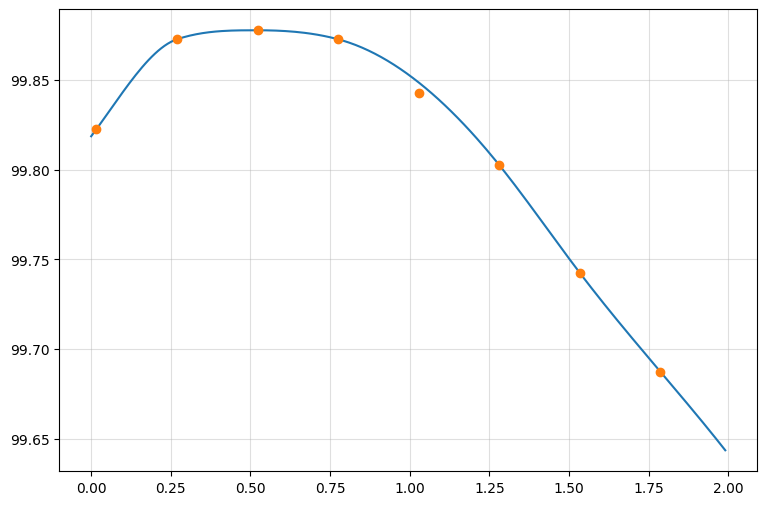

In [86]:
ts, fs = zip(*[(t, f(t, True)) for t in np.arange(0.0, 2.0, 0.01)])
ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.plot(ts, fs)
ax.plot(times, quotes, "o")
ax.grid(alpha=0.4);

We can also ask the interpolation for the estimated value, convert it into the corresponding rate, and compare it with the real one:

In [87]:
quoted = (100 - quotes[4]) / 100
estimated = (100 - f(times[4])) / 100
print(f"{quoted:.3%}")
print(f"{estimated:.3%}")

0.157%
0.152%


To account for the jump, we can estimate the corresponding discount factor $e^{-J*\tau}$ (where both $J$ and $\tau$ are calculated with respect to the tenor of the futures) and add it to the curve.

In [88]:
J = quoted - estimated
tau = day_counter.yearFraction(ql.Date(18, ql.December, 2013), ql.Date(18, ql.March, 2014))
print(f"{J:.5%}")
print(tau)

0.00597%
0.25


In [89]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(np.exp(-J * tau)))]
jump_dates = [ql.Date(31, ql.December, 2013)]
euribor3m_curve = ql.PiecewiseLogCubicDiscount(
    2,
    ql.TARGET(),
    helpers + synth_helpers,
    ql.Actual365Fixed(),
    jumps,
    jump_dates,
)
euribor3m_curve.enableExtrapolation()

We can now reproduce figure 30 in the paper. The end-of-year jump can be seen clearly in the first plot.

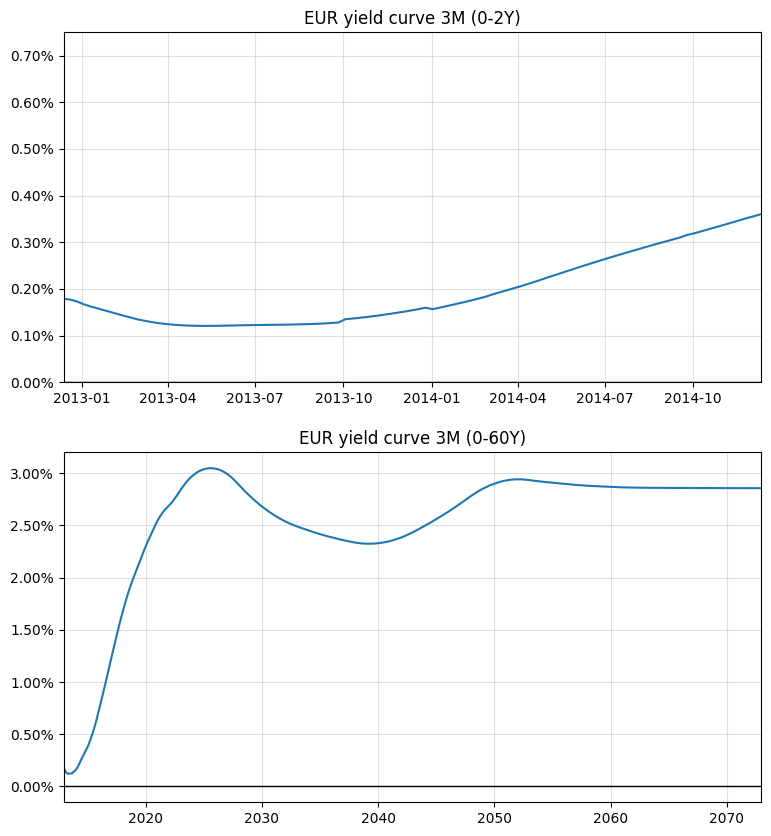

In [90]:
fig = plt.figure(figsize=(9, 10))

spot = euribor3m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [
    euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("EUR yield curve 3M (0-2Y)")
ax1.axhline(0.0, linewidth=1, color="black")
ax1.set_xlim(min(dates).to_date(), max(dates).to_date())
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_ylim(0.0, 0.0075)
ax1.plot([d.to_date() for d in dates], rates, "-")
ax1.grid(alpha=0.4)

dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [
    euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("EUR yield curve 3M (0-60Y)")
ax2.axhline(0.0, linewidth=1, color="black")
ax2.set_xlim(min(dates).to_date(), max(dates).to_date())
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.plot([d.to_date() for d in dates], rates, "-")
ax2.grid(alpha=0.4);

## 1-month Euribor curve

Last, let's bootstrap the 1-month Euribor curve. The used instruments are listed in figures 27.

The short end of the curve includes the 1-month deposit and a strip of interest-rate swaps paying a monthly fixed rate against 1-month Euribor with maturities up to 1 year.

In [91]:
depo_data = all_deposit_data[all_deposit_data["Underlying"] == "Euribor1M"]
depo_data

,Instrument,Quote,Underlying,Start date,Maturity date,Settlement days,Convention,End of month
6,Depo 1M,0.11,Euribor1M,2012-12-13,2013-01-14,2,Mod.Following,True


In [92]:
irs_data = all_irs_data[all_irs_data["Underlying"] == "Euribor1M"]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
65,AB1E2M,0.106,Euribor1M,2012-12-13,2013-02-13
66,AB1E3M,0.096,Euribor1M,2012-12-13,2013-03-13
67,AB1E4M,0.085,Euribor1M,2012-12-13,2013-04-15
68,AB1E5M,0.079,Euribor1M,2012-12-13,2013-05-13
69,AB1E6M,0.075,Euribor1M,2012-12-13,2013-06-13
70,AB1E7M,0.071,Euribor1M,2012-12-13,2013-07-15
71,AB1E8M,0.069,Euribor1M,2012-12-13,2013-08-13
72,AB1E9M,0.066,Euribor1M,2012-12-13,2013-09-13
73,AB1E10M,0.065,Euribor1M,2012-12-13,2013-10-14
74,AB1E11M,0.064,Euribor1M,2012-12-13,2013-11-13


In [93]:
euribor1m = ql.Euribor1M()
helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period("1M"),
        row["Settlement days"],
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for _, row in depo_data.iterrows()
]


def tenor(code):
    # AB1E, then the tenor
    return code[4:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100)),
        ql.Period(tenor(row["Instrument"])),
        ql.TARGET(),
        ql.Monthly,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor1m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for _, row in irs_data.iterrows()
]

For longer maturities, we can combine the swaps against 6-months Euribor with the 1-month vs 6-months basis swaps shown in figure 15.

In [94]:
basis_data = all_irbs_data[1:16]
basis_data

,Instrument,Quote,Underlying 1st leg,Underlying 2nd leg,Start date,Maturity date
1,1E6E2Y,22.6,Euribor1M,Euribor6M,2012-12-13,2014-12-15
2,1E6E3Y,23.8,Euribor1M,Euribor6M,2012-12-13,2015-12-14
3,1E6E4Y,24.6,Euribor1M,Euribor6M,2012-12-13,2016-12-13
4,1E6E5Y,25.0,Euribor1M,Euribor6M,2012-12-13,2017-12-13
5,1E6E6Y,25.0,Euribor1M,Euribor6M,2012-12-13,2018-12-13
6,1E6E7Y,24.8,Euribor1M,Euribor6M,2012-12-13,2019-12-13
7,1E6E8Y,24.5,Euribor1M,Euribor6M,2012-12-13,2020-12-14
8,1E6E9Y,24.1,Euribor1M,Euribor6M,2012-12-13,2021-12-13
9,1E6E10Y,23.7,Euribor1M,Euribor6M,2012-12-13,2022-12-13
10,1E6E11Y,23.3,Euribor1M,Euribor6M,2012-12-13,2023-12-13


In [95]:
irs_data = pd.concat([all_irs_data[4:15], all_irs_data.loc[[17, 22, 27, 32]]])
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
4,AB6E2Y,0.324,Euribor6M,2012-12-13,2014-12-15
5,AB6E3Y,0.424,Euribor6M,2012-12-13,2015-12-14
6,AB6E4Y,0.576,Euribor6M,2012-12-13,2016-12-13
7,AB6E5Y,0.762,Euribor6M,2012-12-13,2017-12-13
8,AB6E6Y,0.954,Euribor6M,2012-12-13,2018-12-13
9,AB6E7Y,1.135,Euribor6M,2012-12-13,2019-12-13
10,AB6E8Y,1.303,Euribor6M,2012-12-13,2020-12-14
11,AB6E9Y,1.452,Euribor6M,2012-12-13,2021-12-13
12,AB6E10Y,1.584,Euribor6M,2012-12-13,2022-12-13
13,AB6E11Y,1.703,Euribor6M,2012-12-13,2023-12-13


In [96]:
def tenor(code):
    # 1E6E, then the tenor
    return code[4:]


helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(irs["Quote"] / 100 - basis["Quote"] / 10000)),
        ql.Period(tenor(basis["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor1m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for (_, basis), (_, irs) in zip(basis_data.iterrows(), irs_data.iterrows())
]

As before, we can use synthetic deposits for maturities below the 1-month tenor...

In [97]:
depo_data = [
    ("1D", 0.0661),
    ("1W", 0.0980),
    ("2W", 0.0993),
    ("3W", 0.1105),
]

In [98]:
synth_helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(quote / 100)),
        ql.Period(tenor),
        2,  # Settlement days
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for tenor, quote in depo_data
]

...and we'll extend the 30-years basis spread flatly to combine it with longer-maturity swaps against 6-months Euribor.

In [99]:
irs_data = all_irs_data[33:37]
irs_data

,Instrument,Quote,Underlying,Start date,Maturity
33,AB6E35Y,2.295,Euribor6M,2012-12-13,2047-12-13
34,AB6E40Y,2.348,Euribor6M,2012-12-13,2052-12-13
35,AB6E50Y,2.421,Euribor6M,2012-12-13,2062-12-13
36,AB6E60Y,2.463,Euribor6M,2012-12-13,2072-12-13


In [100]:
def tenor(code):
    # AB6E, then the tenor
    return code[4:]


last_basis = basis_data["Quote"][basis_data.last_valid_index()]
synth_helpers += [
    ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["Quote"] / 100 - last_basis / 10000)),
        ql.Period(tenor(row["Instrument"])),
        ql.TARGET(),
        ql.Annual,
        ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis),
        euribor1m,
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
        discount_curve,
        2,  # Settlement days
    )
    for _, row in irs_data.iterrows()
]

This curve, too, shows a jump at the end of the year.  The paper claims that it can be determined and corrected by interpolating the quoted swaps with maturities from 1 to 12 months, but I haven't reproduced the calculation yet. For the time being, I'll just use the value reported in the paper and calculate the corresponding discount factor.

In [101]:
J = 0.0016
t_j = euribor1m.dayCounter().yearFraction(
    ql.Date(31, ql.December, 2012), ql.Date(2, ql.January, 2013)
)
B = 1.0 / (1.0 + J * t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31, ql.December, 2013)]

In [102]:
euribor1m_curve = ql.PiecewiseLogCubicDiscount(
    2,
    ql.TARGET(),
    helpers + synth_helpers,
    ql.Actual365Fixed(),
    jumps,
    jump_dates,
)
euribor1m_curve.enableExtrapolation()

This last curve gives us figure 28 in the paper, down to the oscillations during the first year.

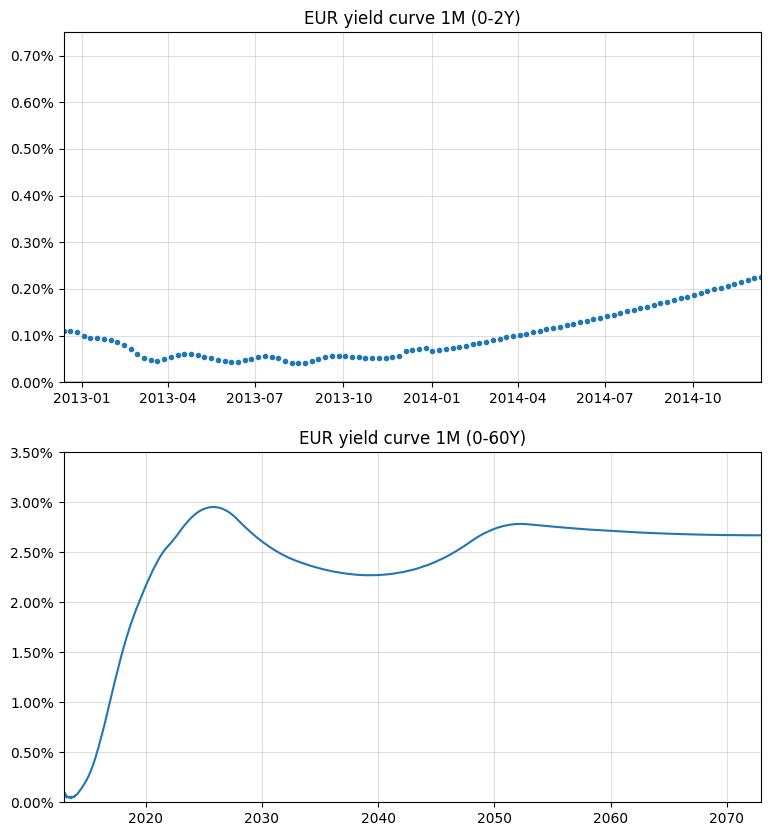

In [103]:
fig = plt.figure(figsize=(9, 10))

spot = euribor1m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [
    euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("EUR yield curve 1M (0-2Y)")
ax1.axhline(0.0, linewidth=1, color="black")
ax1.set_xlim(min(dates).to_date(), max(dates).to_date())
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_ylim(0.0, 0.0075)
ax1.plot([d.to_date() for d in dates], rates, ".")
ax1.grid(alpha=0.4)

dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [
    euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d), ql.Actual360(), ql.Simple).rate()
    for d in dates
]

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("EUR yield curve 1M (0-60Y)")
ax2.set_xlim(min(dates).to_date(), max(dates).to_date())
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.set_ylim(0.0, 0.035)
ax2.plot([d.to_date() for d in dates], rates, "-")
ax2.grid(alpha=0.4);

## Basis curves

Finally, like the authors of the paper, we summarize the results by calculating the difference between the FRA rates calculated on the corresponding Euribor curve and those calculated on the ON curve. This lets us reproduce the top panel of figure 35, and ends this notebook.

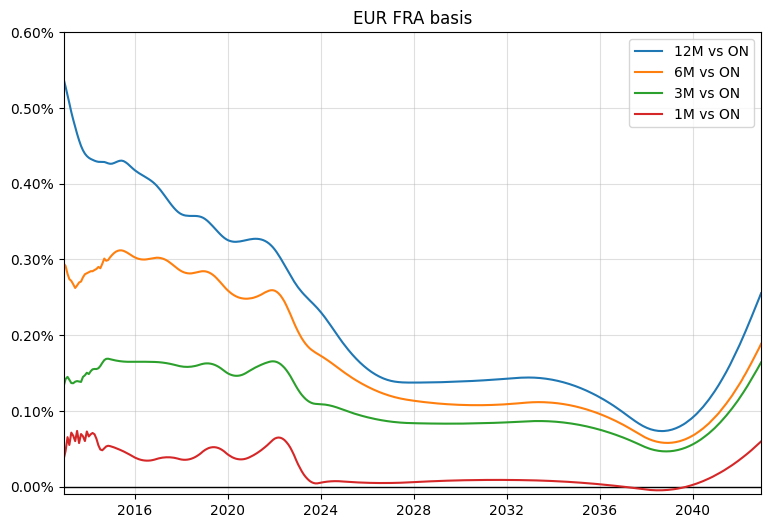

In [104]:
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 12 * 30 + 1)]


def basis(curve, tenor):
    results = []
    for d in dates:
        d2 = ql.TARGET().advance(d, ql.Period(*tenor), ql.ModifiedFollowing)
        FRA1 = curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        FRA2 = eonia_curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        results.append(FRA1 - FRA2)
    return results


basis_1m = basis(euribor1m_curve, (1, ql.Months))
basis_3m = basis(euribor3m_curve, (3, ql.Months))
basis_6m = basis(euribor6m_curve, (6, ql.Months))
basis_12m = basis(euribor12m_curve, (12, ql.Months))

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.set_title("EUR FRA basis")
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(dates).to_date(), max(dates).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(-0.0001, 0.006)
ax.plot([d.to_date() for d in dates], basis_12m, "-", label="12M vs ON")
ax.plot([d.to_date() for d in dates], basis_6m, "-", label="6M vs ON")
ax.plot([d.to_date() for d in dates], basis_3m, "-", label="3M vs ON")
ax.plot([d.to_date() for d in dates], basis_1m, "-", label="1M vs ON")
ax.grid(alpha=0.4)
ax.legend();